## Function for some basic summary plots for RADseq data.

In [6]:
% matplotlib inline
from __future__ import division

In [7]:
### Function for plotting the missing data in a VCF

def Summary_plotter(input_vcf_path, switches = 111, sort = True):
    
    """
    Summary plotter plots some standard metrics for a dataset. Plots missing data per sample, coverage per sample and heterozygosity Vs. coverage accross samples and loci. 
    
    input_vcf_path = full path to vcf
    switches = vector of four 0 or 1 switches for the missing data, coverage and heterozygosity plots in that order. Example: "1101".
    sort = True or False - whether to sort the samples by the plotted metric (True), or keep order in vcf (False)
    """

    from matplotlib import pyplot as plt
    from matplotlib import gridspec
    import numpy as np
    import operator
    
    
    
    input_vcf = open(input_vcf_path, 'r').readlines()
    
    samples_ordered = [] ## get samples in the order they are in the vcf
    
    per_sample_missing_data = {} ## record missing data per sample
    per_sample_coverage = {} ## record coverage per sample
    per_sample_heterozygosity = {} ## recordN heterozygous loci per sample
    
    per_locus_coverage = {} ## record the average coverage per locus across samples
    per_locus_heterozygosity = {}  ## record the proportion of heterozygous samples for each locus
    
    
    format_fields = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
    
    N_loci = 0
    
    for line in input_vcf:
        
        if line.startswith("#CHROM"):
            for field in line.split():
                if field not in format_fields:
                    if field not in per_sample_missing_data:
                        per_sample_missing_data[field] = 0
                        per_sample_coverage[field] = []
                        per_sample_heterozygosity[field] = 0
                        
                        samples_ordered.append(field)
                        

        elif not line.startswith("#"):
            
            N_loci += 1
            
            record_ID = "%s_%s" % (line.split()[2], line.split()[1])
            
            NS = int(line.split()[7].split(";")[0].split("=")[1])
            
            record = line.split()[9:]
            
            N_samples_het = 0
            
            record_coverage_list = []
            
            sample_index = 0
            
            for sample_field in record:
                
                sample_name = samples_ordered[sample_index]
                                
                DP = sample_field.split(":")[1]
                
                per_sample_coverage[sample_name].append(int(DP))
                record_coverage_list.append(int(DP))
                
                
                GT = sample_field.split(":")[0]
                
                if GT == "1/0" or GT == "0/1":
                    
                    per_sample_heterozygosity[sample_name] += 1
                    
                    N_samples_het += 1                    
                
                elif GT == "./.":
                    per_sample_missing_data[sample_name] += 1
                    
                sample_index += 1
        
            per_locus_heterozygosity[record_ID] = N_samples_het/NS
            per_locus_coverage[record_ID] = np.mean(record_coverage_list)

    
    ### Get the means of the samples
    
    per_sample_coverage_means = {}
        
    for sample in per_sample_coverage:
        per_sample_coverage_means[sample] = np.mean(per_sample_coverage[sample])
    
    

    ####### Make plots ###############
    
    fig = plt.figure(figsize = (30,70))  

    
    if switches[0] == "1": ## make the missing data plot
        
        
        if sort == True:

            ## order the missing data

            missing_sorted_sample_names = [i[0] for i in sorted(per_sample_missing_data.items(), key=operator.itemgetter(1), reverse=True)]
    
        else:
            missing_sorted_sample_names = samples_ordered
        
         
        ## Plot figure
        
        #fig = plt.figure(figsize = (30,10))
        
        ax1 = plt.subplot2grid((4,2),(0,0),colspan=2) 
        
        #ax = fig.add_subplot(111)
        
        bar_pos = 1
        
        x_tick_pos = []
        x_tick_labs = []
        
        for sample in missing_sorted_sample_names:
            x_tick_labs.append(sample)
            x_tick_pos.append(bar_pos)
            ax1.bar(bar_pos, per_sample_missing_data[sample], color = "royalblue", align = "center")
            bar_pos += 1
        
        ax1.hlines(np.mean(per_sample_missing_data.values()), 0, len(per_sample_missing_data))
        
        plt.xticks(x_tick_pos, x_tick_labs, rotation = 90)
        plt.title("Missing data per sample")
        #plt.show()
        
    
    
    if switches[1] == "1": ## make the heterozygosity plot
                

        ## Plot figure
        
        #fig = plt.figure(figsize = (30,10))
        
        #ax = fig.add_subplot(111)
        
        ax2 = plt.subplot2grid((4,2),(1,0),colspan=2)
        
        bar_pos = 1
        
        x_tick_pos = []
        x_tick_labs = []
        
        prop_hets = {}
        
        ## First pass to calculate the heterozyousity as a proportion across all loci for each sample
        
        for sample in per_sample_heterozygosity:
            
            if per_sample_missing_data[sample] == 0:
                N_called = N_loci
            else:
                N_called = N_loci - per_sample_missing_data[sample]
            
            if N_called == 0:
                N_called = 1
            
            het_prop = per_sample_heterozygosity[sample]/N_called ## calculate proportion heterozygous
            
            prop_hets[sample] = het_prop
            
            
        if sort == True:

            ## order the missing data

            heterozygosity_sorted_sample_names = [i[0] for i in sorted(prop_hets.items(), key=operator.itemgetter(1), reverse=True)]  
        else:
            heterozygosity_sorted_sample_names = samples_ordered
            

        
        ## Second pass to plot
        
        for sample in heterozygosity_sorted_sample_names:    
            
            x_tick_labs.append(sample)
            x_tick_pos.append(bar_pos)
            
            ax2.bar(bar_pos, prop_hets[sample] , color = "orange", alpha = 0.7, align = "center")

            bar_pos += 1
        
        
        
        ax2.hlines(np.mean(prop_hets.values()), 0, len(per_sample_missing_data))
        
        plt.xticks(x_tick_pos, x_tick_labs, rotation = 90)
        plt.title("N heterozygous loci per sample")
        #plt.show()
    
    
    if switches[2] == "1": ## make the coverage plot
        
        
        overall_mean = np.mean(per_sample_coverage_means.values())
        
        
        if sort == True:

            ## order the missing data

            coverage_sorted_sample_names = [i[0] for i in sorted(per_sample_coverage_means.items(), key=operator.itemgetter(1), reverse=True)]  
        else:
            coverage_sorted_sample_names = samples_ordered
             
        
        
        #fig = plt.figure(figsize = (30,10))
        
        #ax = fig.add_subplot(111)
        
        ax3 = plt.subplot2grid((4,2),(2,0),colspan=2)
        
        
        vio_pos = 1
        
        x_tick_pos = []
        x_tick_labs = []
        
        for sample in coverage_sorted_sample_names:
            
            x_tick_pos.append(vio_pos)
            x_tick_labs.append(sample)
            
            if sum(per_sample_coverage[sample]) == 0:
                per_sample_coverage[sample].append(1)
                        
            
            vio = ax3.violinplot(per_sample_coverage[sample], positions = [vio_pos], showmeans=True,showextrema = False )
                        
            for pc in vio['bodies']:
                pc.set_facecolor('darkgreen')
                pc.set_edgecolor('black')
                pc.set_alpha(0.5)
                
            vio["cmeans"].set_color("black")
            
            vio_pos += 1
            
        plt.xticks(x_tick_pos, x_tick_labs, rotation = 90)
        plt.title("Locus coverage per sample")
    
            
    if switches[3] == "1": ## make the coverage vs Heterozygosity plots (per sample and per locus). Might take a little time for big datasets
        
        ## no sorting required here
        
        #fig = plt.figure(figsize = (30,15))
        
        #ax = fig.add_subplot(121)
        
        ax4 = plt.subplot2grid((4,2),(3,0))

        
        for sample in per_sample_coverage:
            
            if per_sample_missing_data[sample] == 0:
                N_called = N_loci
            else:
                N_called = N_loci - per_sample_missing_data[sample]
            
            if N_called == 0:
                N_called = 1
            
            ax4.scatter(per_sample_heterozygosity[sample]/N_called, per_sample_coverage_means[sample], color = "black")
            ax4.text((per_sample_heterozygosity[sample]/N_called)+0.002, per_sample_coverage_means[sample], sample[:10])
            
        plt.ylabel("Coverage (reads)")
        plt.xlabel("Prop. heterozygous loci")
        plt.title("Coverage Vs Heterozygosity")

        
        
        #ax1 = fig.add_subplot(122)
        
        ax5 = plt.subplot2grid((4,2),(3,1))
        
        for record in per_locus_coverage:
            
            ax5.scatter(per_locus_heterozygosity[record], per_locus_coverage[record], color = "black")
            
        plt.title("Per locus coverage vs heterozygosity")
        plt.xlabel("Prop. heterozygous samples")
        plt.ylabel("Mean coverage across samples")
        
    
    outfile = "%s_VCF_summary_stats.pdf" % input_vcf_path.rpartition(".")[0]
    
    plt.savefig(outfile)
    
    plt.show()
        
    print "#### DONE ####\n"
    
    print "Number of Loci = %s" %N_loci
    
    print "Average coverage = %s reads" % overall_mean
    
    
        
        

In [ ]:
## Cline args

if len(sys.argv) == 1:
    # sys.exit(help(VCF_MSTmap_converter))
    print Summary_plotter.__doc__
    
elif len(sys.argv) < 3: ## If not enough args are supplied print error message
    sys.exit("\n##Error, not enough arguments, run script with no arguments to see help message\n")

elif len(sys.argv) == 3:
    vcf_file = sys.argv[1]
    switches = sys.argv[2]
    sort = sys.argv[3]

    Summary_plotter(vcf_file, switches, sort)

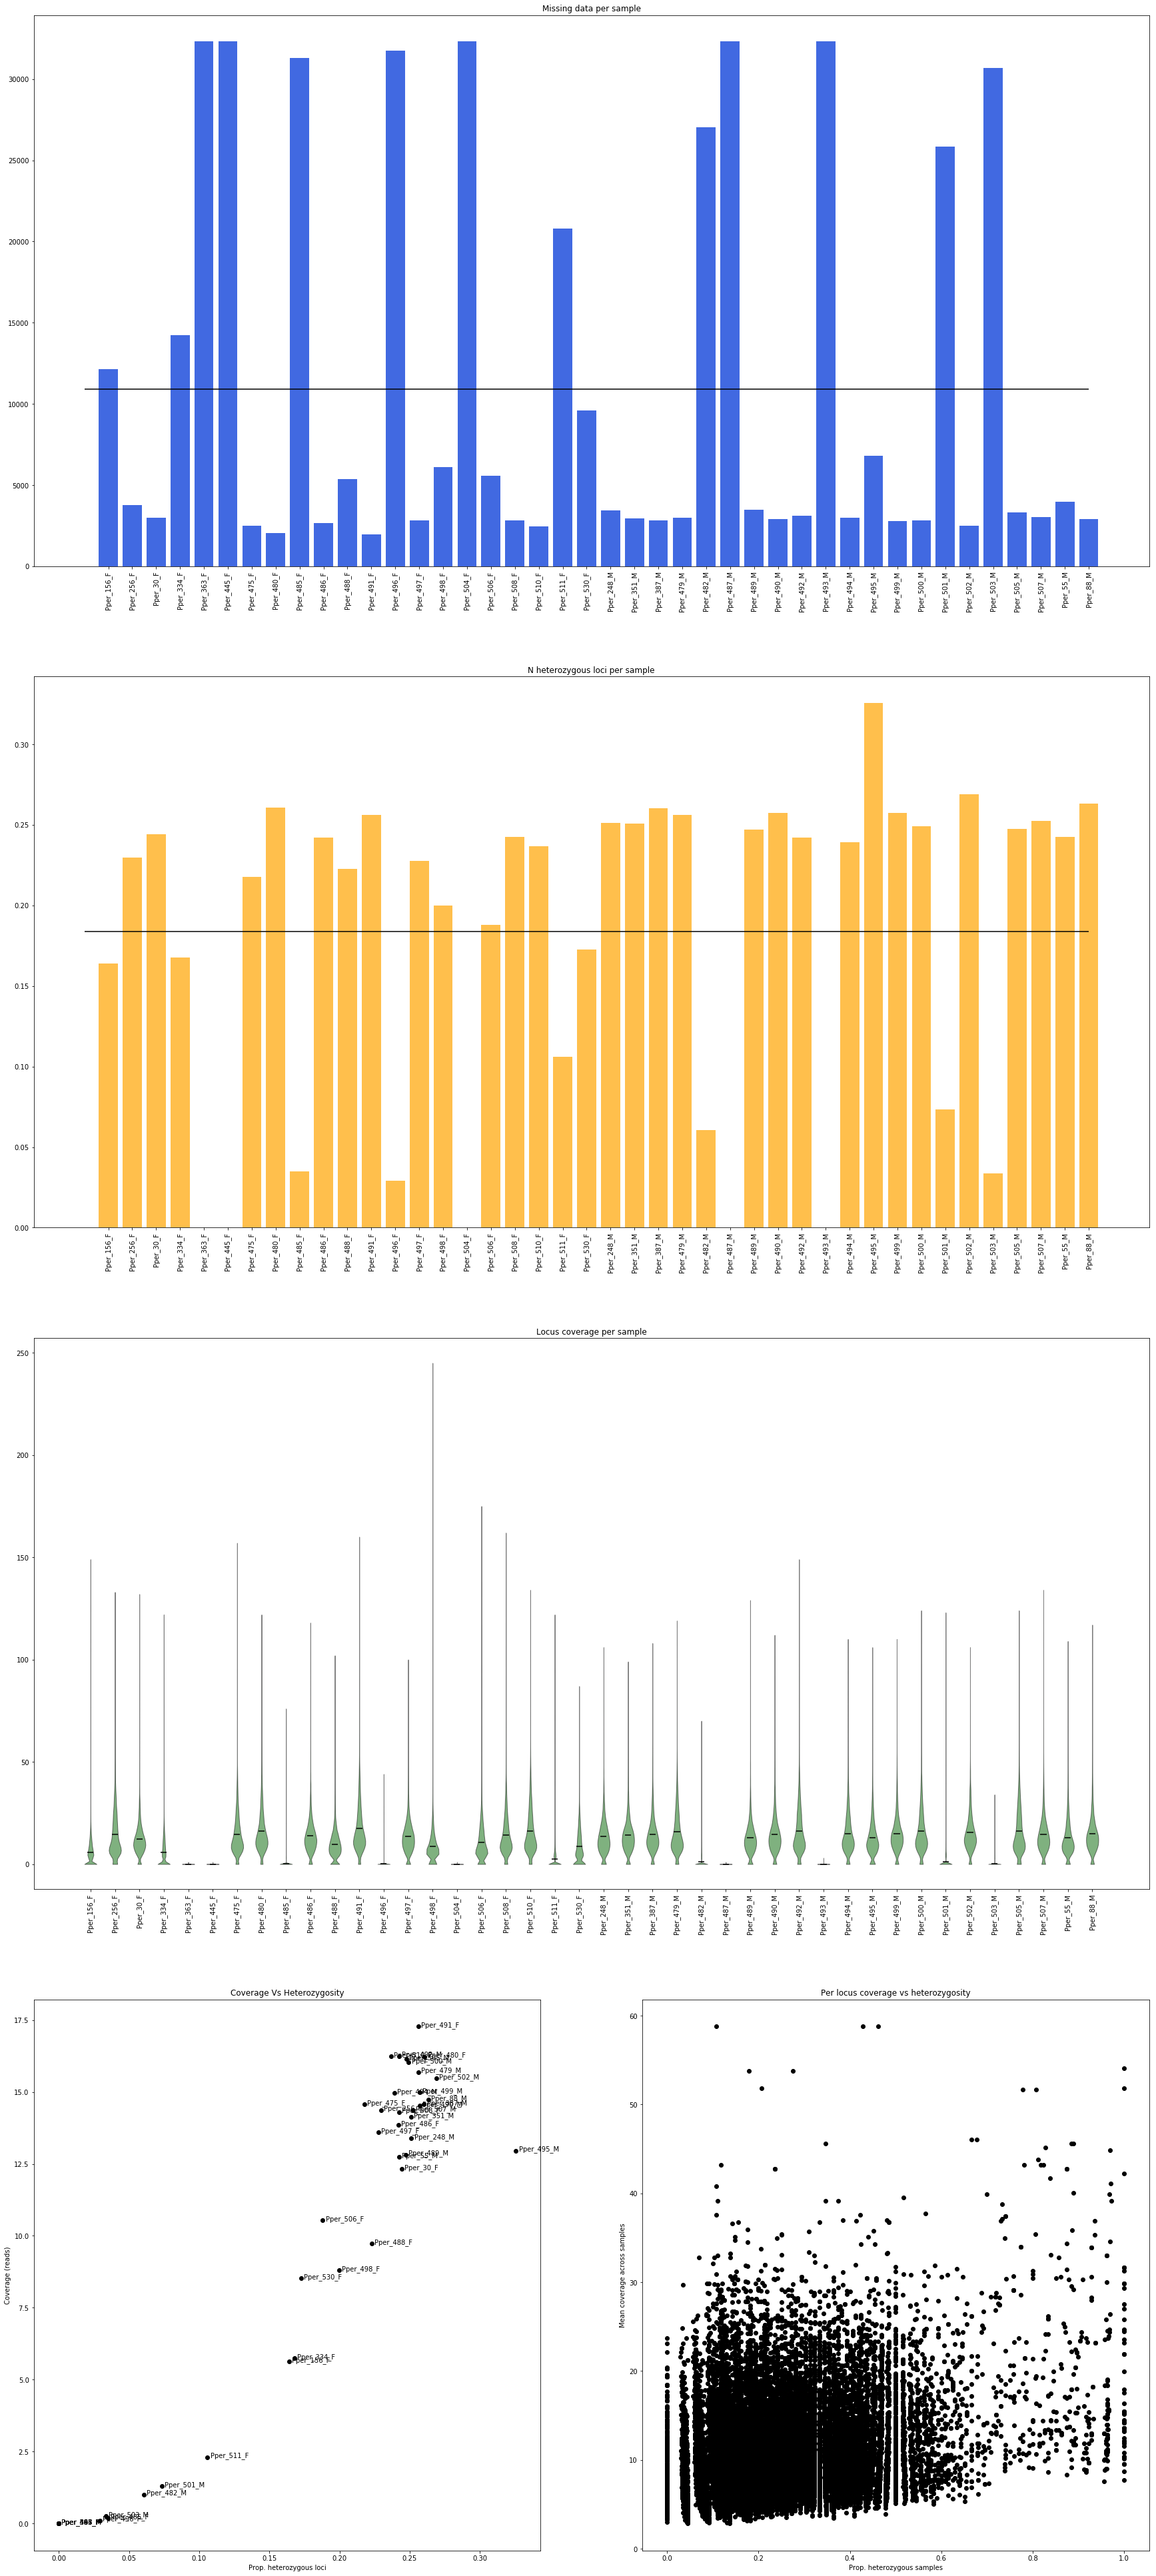

#### DONE ####

Number of Loci = 32326
Average coverage = 10.0152501451 reads


In [3]:
from MISC_RAD_tools import Summary_plotter as SP

SP("~/Data/RADseq/Riberica/Stacks_trimmed/IDd/Populations_N_spain/batch_1.vcf", "1111", False)
